# Sales Prediction

Using machine learning to help organization prepare to handle dynamic market demand. Organization may infer the prediction to establish rule, plan, or strategy to further strengthen market position.

## Library Import and Configuration

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from util.dbconn import DbConn

In [2]:
WAREHOUSE_CONN = {
    'user': 'postgres',
    'password': 'qshOke46RvOg0',
    'host': 'localhost',
    'port': '8084',
    'dbname': 'postgres'
}

In [3]:
postgres_conn = DbConn(WAREHOUSE_CONN).get_conn()

## Data Overview

In [4]:
sql = """SELECT 
	dd."year",
	dd."month",
	dd.week_num_in_year,
	dd."date",
	count(DISTINCT fo.order_legacy_id) as count_order
FROM 
	warehouse.fact_order fo
LEFT JOIN warehouse.date_dim dd ON
	fo.order_date = dd.date_id
GROUP BY 1,2,3,4;
"""

In [5]:
df = pd.read_sql(sql=sql, con=postgres_conn)

display(df.info())
display(df.describe())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   year              634 non-null    int64
 1   month             634 non-null    int64
 2   week_num_in_year  634 non-null    int64
 3   date              634 non-null    int64
 4   count_order       634 non-null    int64
dtypes: int64(5)
memory usage: 24.9 KB


None

,year,month,week_num_in_year,date,count_order
count,634.000000,634.000000,634.000000,634.000000,634.000000
mean,2017.383281,5.938486,24.501577,15.597792,156.847003
std,0.533051,3.214452,14.111411,8.768610,94.224817
min,2016.000000,1.000000,1.000000,1.000000,1.000000
25%,2017.000000,3.000000,13.000000,8.000000,96.000000
50%,2017.000000,6.000000,24.000000,15.500000,148.000000
75%,2018.000000,8.000000,35.000000,23.000000,215.750000
max,2018.000000,12.000000,53.000000,31.000000,1176.000000


,year,month,week_num_in_year,date,count_order
0,2016,9,36,4,1
1,2016,9,37,5,1
2,2016,9,38,13,1
3,2016,9,38,15,1
4,2016,10,40,2,1


### Check Null Values

In [6]:
df.isnull().sum()

year                0
month               0
week_num_in_year    0
date                0
count_order         0
dtype: int64

## Exploratory Data Analysis

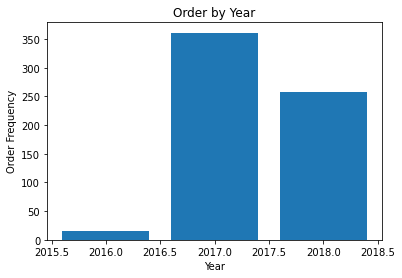

,year,count_order
0,2016,15
1,2017,361
2,2018,258


In [7]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'count_order']].groupby('year', as_index=False).count()

ax.bar(_df_temp['year'], _df_temp['count_order'])
ax.set_title('Order by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

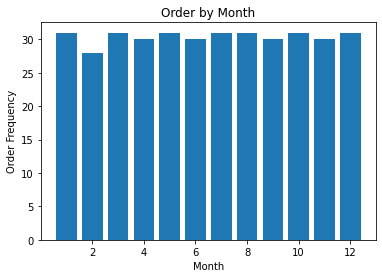

,year,month,count_order
0,2016,9,4
1,2016,10,10
2,2016,12,1
3,2017,1,27
4,2017,2,28
5,2017,3,31
6,2017,4,30
7,2017,5,31
8,2017,6,30
9,2017,7,31


In [8]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['year', 'month', 'count_order']] \
            .groupby(by=['year', 'month'], as_index=False) \
            .count()

ax.bar(_df_temp['month'], _df_temp['count_order'])
ax.set_title('Order by Month')
ax.set_xlabel('Month')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

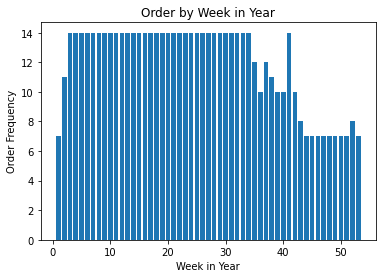

,week_num_in_year,count_order
0,1,7
1,2,11
2,3,14
3,4,14
4,5,14
5,6,14
6,7,14
7,8,14
8,9,14
9,10,14


In [9]:
fig, ax = plt.subplots()

_df_temp = df.loc[:, ['week_num_in_year', 'count_order']] \
            .groupby(by='week_num_in_year', as_index=False) \
            .count()

ax.bar(_df_temp['week_num_in_year'], _df_temp['count_order'])
ax.set_title('Order by Week in Year')
ax.set_xlabel('Week in Year')
ax.set_ylabel('Order Frequency')

plt.show()
display(_df_temp.head(15))

In [10]:
model_df = df.copy()

## Data Preprocessing

In [11]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
normalizer = Normalizer(norm='l2')
standardize = StandardScaler()

## Naive Model

In [12]:
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error

In [13]:
y = model_df.loc[:, 'count_order']
# Set to predict the mean
y_pred = [y.mean() for i in range(0, len(y))]

mse = mean_squared_error(y, y_pred)
print(mse)

8864.3125541104


## Feature Engineering

In [14]:
def shift(data, n_in=1, n_out=1, dropna=True):
    """
    Arguments:
        data: Sequence of observations as DataFrame or Numpy Array.
        n_in: Number of lag observations as input.
        n_out: Number of observations as output.
        dropna: Boolean whether to drop rows with NaN values.
    Returns:
        df: Pandas DataFrame
    """
    
    try:
        var = range(0, data.shape[1]) if isinstance(data, np.ndarray) else \
                data.columns if isinstance(data, pd.DataFrame) else None
    except IndexError as e:
        var = range(0, 1)
    
    if var is None:
        raise Exception('Expected pandas.DataFrame or numpy.ndarray got {}'.format(type(data)))
    
    df = pd.DataFrame(data)
    cols, names = [], []
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('{n}(t-{i})'.format(n=v, i=i)) for v in var]
    
    for i in range(0, n_out):
        cols.append(df.shift(i))
        if i == 0:
            names += [('{n}(t)'.format(n=v)) for v in var]
        else:
            names += [('{n}(t+{i})'.format(n=v, i=i)) for v in var]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropna:
        agg.dropna(inplace=True)
    
    return agg

In [15]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

In [16]:
shifted = shift(y, 2, 1, dropna=False)

In [17]:
shifted.loc[:, ['0(t-2)','0(t-1)']].to_numpy()

array([[nan, nan],
       [nan,  1.],
       [ 1.,  1.],
       ...,
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [19]:
_X = np.concatenate((X, shifted), axis=1)

_X = pd.DataFrame(_X)
_X = _X.dropna()
_X = _X.to_numpy()

_y = y[2:]

## MLP Regressor

In [20]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit

In [21]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [22]:
from sklearn.metrics import make_scorer

In [ ]:
mse_scorer = make_scorer(mean_squared_error)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('mlp', MLPRegressor())])

param_grid = dict(mlp__hidden_layer_sizes=[(100,),(100,30),(100,30,10)],
                  mlp__activation=['identity', 'relu', 'logistic'],
                  mlp__max_iter=[200, 500, 1000, 2000],
                  mlp__learning_rate_init=[0.003,0.005,0.01,0.05],
                  mlp__solver=['lbfgs', 'sgd', 'adam'])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
                    scoring=mse_scorer, n_jobs=1, verbose=1)
grid.fit(_X, _y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

In [27]:
# print(grid.best_score_)
# print(grid.best_estimator_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [18]:
tscv = TimeSeriesSplit()

errors = []

mlpr = MLPRegressor()
# model = make_pipeline(normalizer, mlpr)
model = make_pipeline(standardize, mlpr)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    errors.append(mse)
    
print(sum(errors)/len(errors))

/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.wa

17461.60439509685


/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [19]:
## DO NOT DELETE
# mlpr = MLPRegressor(
#             hidden_layer_sizes=(100,30),
#             activation='relu',
#             solver='lbfgs',
#             learning_rate='constant',
#             learning_rate_init=0.001,
#             max_iter=1000)

### Default Parameter

In [20]:
def evaluate_mlpr(y_actual, y_pred):
    med_ae = median_absolute_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mse = mean_squared_error(y_actual, y_pred)
    rmse = mean_squared_error(y_actual, y_pred, squared=False)
    
    return {
        'Median Absolute Error': med_ae,
        'Mean Absolute Error': mae,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
    }

In [21]:
tscv = TimeSeriesSplit()

errors = []

mlpr = MLPRegressor(max_iter=1000)
# model = make_pipeline(normalizer, mlpr)
model = make_pipeline(standardize, mlpr)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors.append(evaluate_mlpr(y_test, y_pred))
    
print(json.dumps(errors[-1], indent=4))

/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warning

{
    "Median Absolute Error": 57.35351217122846,
    "Mean Absolute Error": 86.07240133386136,
    "Mean Squared Error": 13124.448239855776,
    "Root Mean Squared Error": 114.56198426989546
}


/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


### Final Model

In [22]:
tscv = TimeSeriesSplit()

errors = []

mlpr = MLPRegressor(max_iter=1000, activation='identity',
                   solver='sgd', learning_rate='constant',
                   tol=0.005)
# model = make_pipeline(normalizer, mlpr)
model = make_pipeline(standardize, mlpr)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    errors.append(evaluate_mlpr(y_test, y_pred))
    
print(json.dumps(errors[-1], indent=4))

{
    "Median Absolute Error": 81.7504866096175,
    "Mean Absolute Error": 111.00347462969164,
    "Mean Squared Error": 22154.307169352676,
    "Root Mean Squared Error": 148.8432301764265
}


## Support Vector Regression

In [23]:
from sklearn.svm import LinearSVR

In [24]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [33]:
# mse_scorer = make_scorer(mean_squared_error)

# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('svr', LinearSVR())])

# param_grid = dict(svr__tol=[0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05],
#                   svr__max_iter=[1000,2000,5000],
#                   svr__C=[1, 1.5, 2, 2.5, 3, 3.5])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
#                     scoring=mse_scorer, n_jobs=1, verbose=1)
# grid.fit(X, y)

In [26]:
print(grid.best_score_)
print(grid.best_estimator_)

9044.016395567607
Pipeline(steps=[('scale', StandardScaler()), ('svr', LinearSVR(C=2, tol=0.05))])


### Default Parameter

In [27]:
def _tscv(X, estimator):
    tscv = TimeSeriesSplit()

    errors = []
    
    model = make_pipeline(standardize, estimator)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        errors.append(evaluate_mlpr(y_test, y_pred))

    print(json.dumps(errors[-1], indent=4))

In [28]:
svr = LinearSVR()

_tscv(X, svr)

{
    "Median Absolute Error": 56.39899010396201,
    "Mean Absolute Error": 90.32444801713035,
    "Mean Squared Error": 15529.372656266067,
    "Root Mean Squared Error": 124.61690357357651
}


### Final Model

In [37]:
final_svr = LinearSVR(C=2, max_iter=2000, tol=0.05)

_tscv(X, final_svr)

{
    "Median Absolute Error": 69.49538128274946,
    "Mean Absolute Error": 102.58811166752804,
    "Mean Squared Error": 19583.343878727752,
    "Root Mean Squared Error": 139.94050120936308
}


## SGD Regressor

In [30]:
from sklearn.linear_model import SGDRegressor

In [31]:
X = model_df.loc[:, ['year', 'month', 'week_num_in_year', 'date']].to_numpy()
y = model_df.loc[:, 'count_order'].to_numpy()

### Hyperparameter Tuning

In [34]:
mse_scorer = make_scorer(mean_squared_error)

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('sgdr', SGDRegressor())])

param_grid = dict(sgdr__loss=['squared_loss', 'huber'],
                  sgdr__epsilon=[0.1,0.3,0.5],
                  sgdr__learning_rate=['constant', 'invscaling', 'adaptive'],
                  sgdr__eta0=[0.01,0.03,0.05],
                  sgdr__max_iter=[1000,3000,5000],
                  sgdr__alpha=[0.0001,0.0005,0.001])

grid = GridSearchCV(pipe, param_grid=param_grid, cv=TimeSeriesSplit(),
                    scoring=mse_scorer, n_jobs=1, verbose=1)
grid.fit(X, y)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradi

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('sgdr', SGDRegressor())]),
             n_jobs=1,
             param_grid={'sgdr__alpha': [0.0001, 0.0005, 0.001],
                         'sgdr__epsilon': [0.1, 0.3, 0.5],
                         'sgdr__eta0': [0.01, 0.03, 0.05],
                         'sgdr__learning_rate': ['constant', 'invscaling',
                                                 'adaptive'],
                         'sgdr__loss': ['squared_loss', 'huber'],
                         'sgdr__max_iter': [1000, 3000, 5000]},
             scoring=make_scorer(mean_squared_error), verbose=1)

In [35]:
print(grid.best_score_)
print(grid.best_estimator_)

33037.20510750116
Pipeline(steps=[('scale', StandardScaler()),
                ('sgdr', SGDRegressor(alpha=0.001, loss='huber'))])


### Default Parameter

In [29]:
sgdr = SGDRegressor()

_tscv(X, sgdr)

{
    "Median Absolute Error": 88.75331750886312,
    "Mean Absolute Error": 116.70287934944267,
    "Mean Squared Error": 24033.284025696357,
    "Root Mean Squared Error": 155.0267203603829
}


### Final Model

In [30]:
sgdr = SGDRegressor(
            loss='squared_loss',
            penalty='l2',
            eta0=0.01,
            alpha=0.001,
            learning_rate='optimal',
            tol=1e-2,
            max_iter=100000)

_tscv(X, sgdr)

{
    "Median Absolute Error": 2721086.719494314,
    "Mean Absolute Error": 2719474.194309951,
    "Mean Squared Error": 10531263321385.148,
    "Root Mean Squared Error": 3245190.7989184777
}


/home/dionricky/future-data-1/env/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:1225: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "
